Overview : We have created Our own dataset , which we have made by adding scanner noise patterns with automated python code and applied it over the dataset of about 6000 images from kaggle , (we have tested the model on 3000 and even 300 images).

folder structure :

      Scanner-data -
                      -Scanner 1 -> image_sc1.jpg
                      -Scanner 2
                      -Scanner 3

                      (same for others)


Then created SVM Classifier after extracting its important features mentioned in the code.

The SVM Classifier test the best value of penalty number , kernal function
and use it to classify our datapoints


Also we have mentioned 3 ways of how we extracted the features

                

We'll first impliment the noise dataset , making different pattern noise for each scanner

Importing images dataset
Use kaggle.json

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

# Set up Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d prasunroy/natural-images

# Unzip
!unzip natural-images.zip -d natural-images

Streaming output truncated to the last 5000 lines.
  inflating: natural-images/natural_images/cat/cat_0204.jpg  
  inflating: natural-images/natural_images/cat/cat_0205.jpg  
  inflating: natural-images/natural_images/cat/cat_0206.jpg  
  inflating: natural-images/natural_images/cat/cat_0207.jpg  
  inflating: natural-images/natural_images/cat/cat_0208.jpg  
  inflating: natural-images/natural_images/cat/cat_0209.jpg  
  inflating: natural-images/natural_images/cat/cat_0210.jpg  
  inflating: natural-images/natural_images/cat/cat_0211.jpg  
  inflating: natural-images/natural_images/cat/cat_0212.jpg  
  inflating: natural-images/natural_images/cat/cat_0213.jpg  
  inflating: natural-images/natural_images/cat/cat_0214.jpg  
  inflating: natural-images/natural_images/cat/cat_0215.jpg  
  inflating: natural-images/natural_images/cat/cat_0216.jpg  
  inflating: natural-images/natural_images/cat/cat_0217.jpg  
  inflating: natural-images/natural_images/cat/cat_0218.jpg  
  inflating: natura

Made directories

In [2]:
import os
base_dir = "natural-images/natural_images"
scanner_dir = "scanner-data"

#create folders
for category in os.listdir(base_dir):
  for scanner in [1,2,3] :
    os.makedirs(f"{scanner_dir}/scanner{scanner}", exist_ok=True)



In [ ]:
# import shutil

# folder_path = 'scanner-data'  # Replace with the actual path

# shutil.rmtree(folder_path)

This is the old scanner noise, didn't helped much in extracting noise

In [ ]:
# def genScanner1(height,width) :
#   """vertical strips + hot pixels"""
#   xx = np.arange(width); #create an array
#   vertical = np.sin(xx * 0.1) * 10  #creating strips and *10
#   hotPixels = (np.random.rand(height,width) > 0.99 ) * 50 #create 2d array of random no.
#   return vertical + hotPixels

# def genScanner2(height, width):
#     """Diagonal interference + horizontal banding"""
#     xx, yy = np.meshgrid(np.arange(width), np.arange(height))
#     diagonal = np.sin(xx * 0.2 + yy * 0.3) * 5  # Diagonal waves
#     horizontal = np.sin(yy * 0.1) * 3  # Horizontal banding
#     return diagonal + horizontal

# def genScanner3(height, width):
#     """Realistic scanner noise with banding, shading, specks, grain, and dot clusters."""
#     noise = np.zeros((height, width), dtype=np.float32)

#     # 1. Vertical banding
#     band_freq = np.random.uniform(0.005, 0.02)
#     vertical_banding = (np.sin(np.arange(width) * band_freq * 2 * np.pi) * np.random.uniform(1, 3))
#     noise += vertical_banding[np.newaxis, :]

#     # 2. Vertical paper shading
#     shading_gradient = np.linspace(np.random.uniform(-3, -1), np.random.uniform(1, 3), height)
#     noise += shading_gradient[:, np.newaxis]

#     # 3. Horizontal jitter
#     for i in range(0, height, np.random.randint(15, 25)):
#         jitter = np.random.uniform(-2, 2)
#         noise[i:i+1, :] += jitter

#     # 4. Specks (white and black)
#     dust_map = np.random.rand(height, width)
#     noise[dust_map > 0.998] += 25
#     noise[dust_map < 0.002] -= 25

#     # 5. Gaussian grain
#     noise += np.random.normal(0, 0.7, (height, width))

#     # 6. Add little dots (tiny 2x2 or 3x3 clusters)
#     num_dots = 30  # number of dot clusters
#     for _ in range(num_dots):
#         y = np.random.randint(5, height - 5)
#         x = np.random.randint(5, width - 5)
#         dot_size = np.random.choice([2, 3])
#         strength = np.random.uniform(10, 25) * np.random.choice([-1, 1])  # bright or dark
#         noise[y:y+dot_size, x:x+dot_size] += strength

#     return noise


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

These are the scanner noise which we creating , We just used a scanner noise maker code and used it and modified it so it is more comfortable with our Classifier (we don't have a dataset anyway )


In [4]:

def genScanner1(height, width):
    """Enhanced CCD Scanner Noise (Epson-like)"""
    # Stronger vertical banding with sensor column defects
    xx = np.arange(width)
    vertical = np.sin(xx * (0.05 + np.random.rand()*0.03)) * 15  # More prominent stripes

    # Column defects (common in CCD arrays)
    col_defects = np.zeros(width)
    for _ in range(np.random.randint(3,7)):
        pos = np.random.randint(0, width)
        col_defects[pos] = np.random.uniform(10, 30)

    # Hot/dead pixels with clustering
    pixels = np.random.rand(height, width)
    hot = (pixels > 0.995) * np.random.uniform(30, 50, (height, width))
    dead = (pixels < 0.003) * -np.random.uniform(20, 40, (height, width))

    return vertical + col_defects + hot + dead

def genScanner2(height, width):
    """Enhanced CIS Scanner Noise (HP-like)"""
    # Diagonal interference with motor artifacts
    xx, yy = np.meshgrid(np.arange(width), np.arange(height))

    # Motor banding (stronger horizontal components)
    motor_banding = np.sin(yy * 0.15) * 8

    # Diagonal sensor pattern
    diagonal = np.sin(xx*0.1 + yy*0.25) * 6

    # Random line jumps (simulating motor inconsistency)
    for _ in range(np.random.randint(2,5)):
        row = np.random.randint(0, height)
        jump = np.random.uniform(-15, 15)
        diagonal[row:row+np.random.randint(1,3), :] += jump

    return motor_banding + diagonal

def genScanner3(height, width):
    """Professional Scanner Noise (Kodak-like)"""
    noise = np.zeros((height, width), dtype=np.float32)

    # 1. Subtle banding with exact frequency
    band_freq = 1/150  # Simulating 150 DPI sensor pattern
    xx = np.arange(width)
    noise += np.sin(xx * band_freq * 2 * np.pi) * 3

    # 2. Optical vignetting (lens effect)
    yy, xx = np.ogrid[:height, :width]
    center_x, center_y = width/2, height/2
    vignette = np.sqrt((xx-center_x)**2 + (yy-center_y)**2)
    vignette = vignette/vignette.max()
    noise -= vignette * 8  # Darker edges

    # 3. Dust particles (more realistic distribution)
    dust_size = np.random.poisson(3, 20)  # Clustered dust sizes
    for size in dust_size:
        if size < 1: continue
        y = np.random.randint(0, height-size)
        x = np.random.randint(0, width-size)
        noise[y:y+size, x:x+size] -= np.random.uniform(15, 30)

    # 4. Photon shot noise (Poisson distribution)
    noise += np.random.poisson(0.5, (height, width)) - 0.5

    return noise

Just to see how noisy image looks like , we'll just give single image as a input

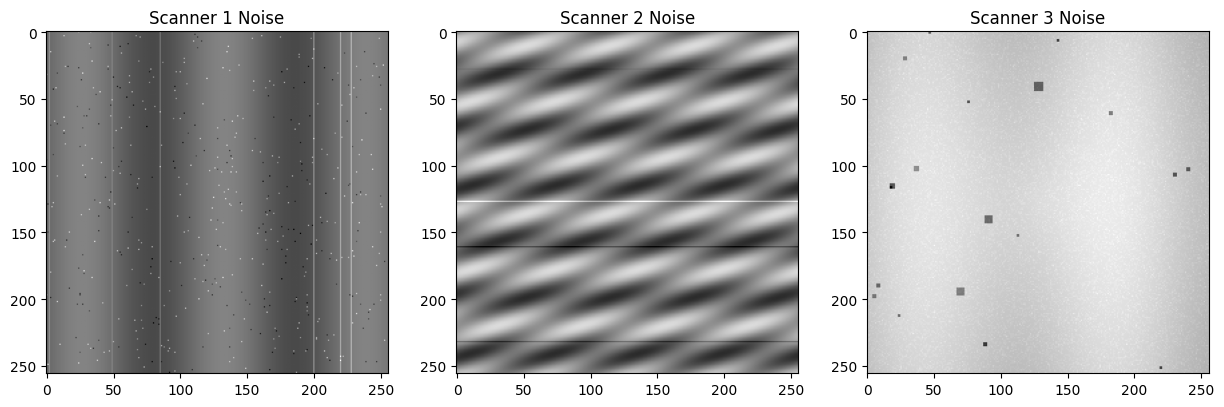

In [5]:
def plot_noise_samples():
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i, noise_func in enumerate([genScanner1, genScanner2, genScanner3]):
        noise = noise_func(256, 256)
        axs[i].imshow(noise, cmap='gray')
        axs[i].set_title(f'Scanner {i+1} Noise')
    plt.show()

plot_noise_samples()

This function is used to just see , how the noise looks in the image , no need to run it

In [6]:
test_img = cv2.imread('test_img.jpg', cv2.IMREAD_GRAYSCALE)
if test_img is None:
    raise FileNotFoundError("Image not found! Check the filename and upload path")

test_img = cv2.resize(test_img, (1024, 768))

plt.figure(figsize=(20,10))

plt.subplot(2,4,1)
plt.title("Original Image")
plt.imshow(test_img, cmap='gray')
plt.axis("off")


height, width = test_img.shape

for i, scanner_func in enumerate([genScanner1, genScanner2, genScanner3]):
    # Generate noise
    noise = scanner_func(*test_img.shape)

    # Create noisy image
    noisy_img = np.clip(test_img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Display results
    plt.subplot(2, 4, i+2)
    plt.imshow(noisy_img, cmap='gray')
    plt.title(f'Scanner {i+1} Noisy Version')
    plt.axis('off')

    plt.subplot(2, 4, i+5)
    plt.imshow(noise, cmap='gray')
    plt.title(f'Scanner {i+1} Noise Pattern')
    plt.axis('off')

plt.tight_layout()
plt.show()

FileNotFoundError: Image not found! Check the filename and upload path

Now actually applying the noise on our dataset and saving it to the respective directories

for now we have set for 300 images, we have used it on 3000 images

In [7]:
import os
import cv2
import numpy as np

def dataset(input_dir, output_dir):
    #move through all the scanners with the count
    scanner_counts = {1: 0, 2: 0, 3: 0}
    max_images_per_scanner = 100

    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)

        for img_file in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_file)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv2.resize(img, (1024, 768))

            height, width = img.shape
            for scanner in [1, 2, 3]:
                # check each scanner should only have 100 imaages
                if scanner_counts[scanner] >= max_images_per_scanner:
                    continue

                # noise
                if scanner == 1:
                    noise = genScanner1(height, width)
                elif scanner == 2:
                    noise = genScanner2(height, width)
                else:
                    noise = genScanner3(height, width)

                noisy_img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

                base_name = os.path.splitext(img_file)[0]
                save_path = f'{output_dir}/scanner{scanner}/{base_name}_sc{scanner}.jpg'

                # Save the noisy image
                cv2.imwrite(save_path, noisy_img)

                # Increment
                scanner_counts[scanner] += 1

                # Optional: if all scanners are done, break early
                if all(count >= max_images_per_scanner for count in scanner_counts.values()):
                    print("Processed 1000 images for each scanner.")
                    return

dataset(base_dir, scanner_dir)


Processed 1000 images for each scanner.


Can save our dataset

In [ ]:
!zip -r scanner-data.zip scanner-data


Streaming output truncated to the last 5000 lines.
  adding: scanner-data/scanner2/flower_0764_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/cat_0399_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/cat_0437_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/airplane_0449_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/flower_0327_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/airplane_0533_sc2.jpg (deflated 1%)
  adding: scanner-data/scanner2/flower_0629_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/person_0126_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/car_0145_sc2.jpg (deflated 1%)
  adding: scanner-data/scanner2/person_0587_sc2.jpg (deflated 1%)
  adding: scanner-data/scanner2/flower_0041_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/dog_0200_sc2.jpg (deflated 0%)
  adding: scanner-data/scanner2/airplane_0039_sc2.jpg (deflated 1%)
  adding: scanner-data/scanner2/airplane_0212_sc2.jpg (deflated 0%)
  adding: scanner-data/scanne

Creating folders for each scanner directories

Old noise patterns generated


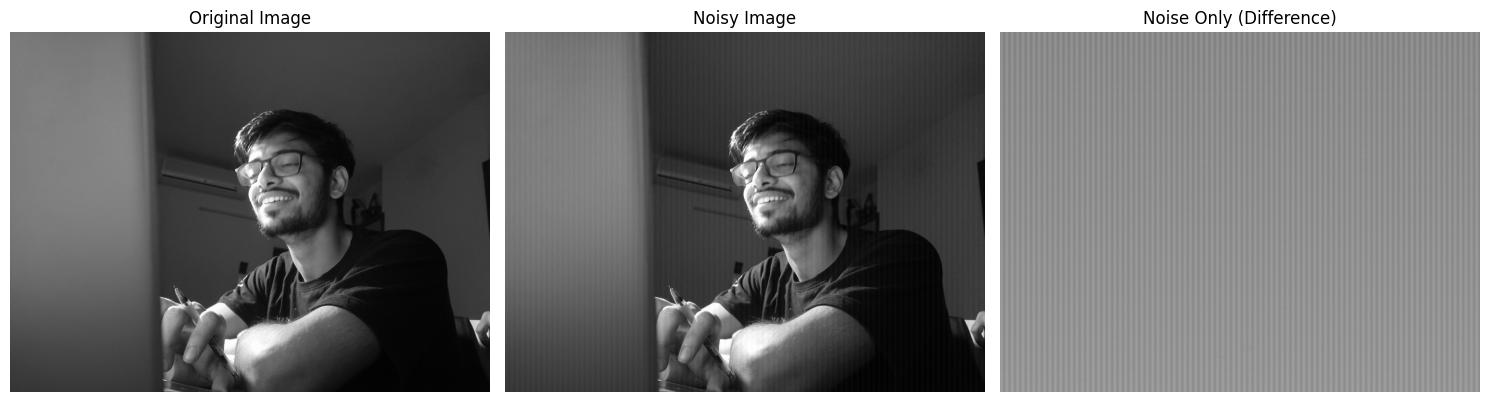

In [ ]:
# test_img = cv2.imread("IMG20250220041110.jpg")
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  # convert to grayscale

# height, width = test_img.shape
# test_noise = genScanner3(height, width)

# # Apply noise
# test_noisy_img = np.clip(test_img.astype(np.float32) + test_noise, 0, 255).astype(np.uint8)

# # Calculate actual noise by subtracting original image from noisy
# visual_noise = (test_noisy_img.astype(np.int16) - test_img.astype(np.int16)) + 128  # offset to make differences visible
# visual_noise = np.clip(visual_noise, 0, 255).astype(np.uint8)

# # Display
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 3, 1)
# plt.title("Original Image")
# plt.imshow(test_img, cmap='gray')
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.title("Noisy Image")
# plt.imshow(test_noisy_img, cmap='gray')
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.title("Noise Only (Difference)")
# plt.imshow(visual_noise, cmap='gray')
# plt.axis("off")

# plt.tight_layout()
# plt.show()

Now We'll use this as a data for our SVM

In [16]:
from scipy import stats

In [34]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler

# Initialize lists to store features and labels
X = []
y = []


Feature extraction acc to paper :

    1. BASIC INTENSITY   
    1) Mean (np.mean): calculates the overall brightness
    2) Median (np.median): Middle value in sorted pixels. Robust to outliers.
    3) Standard Deviation (np.std): variation in pixel values
    4) Skewness (stats.skew): +ve means more bright pixels (vice versa)
    5) Kurtosis (stats.kurtosis): heavy tails, extreme values(hot/dead pixels)

    2. Row-wise Pattern Analysis
    1) Row Correlations (np.corrcoef): similar each row is to the avg row (scanner's fixed noise pattern).
    2) Mean/Median of Correlations: correlation btw rows , high means rows have same pattern of pixel values
    3) Std of Correlations: variablilty in rows
    4) Skew of Correlations: Are most rows strongly correlated (negative skew)?

    3. Column-wise Defect Analysis
    1) Column Std Dev: Variation in cols
    2) Outlier Columns : count of col with abnormal noise

    4. Frequency domain (captures scanner's fixed patterns)
    Low freq = smooth gradients; high freq = sharp edges/noise
    1) FFT Energy (np.fft.fft2):

    5. Hot/Dead Pixels
    Pixels stuck at max/min brightness
    Dust Detection (cv2.GaussianBlur) : Counts sharp defects (dust/scratches)

Feature Extraction like given in the paper, (Paper doesn't have col wise and fft transformation but doing less feature ext , gave us bad results for our dataset)

In [49]:
def extract_features(noisy_img):
    features = []

    features.append(np.mean(noisy_img))
    features.append(np.median(noisy_img))
    features.append(np.std(noisy_img))
    features.append(stats.skew(noisy_img.flatten()))
    features.append(stats.kurtosis(noisy_img.flatten()))

    # 2. Row-wise
    avg_row = np.mean(noisy_img, axis=0)
    row_corrs = [np.corrcoef(avg_row, row)[0,1] for row in noisy_img]

    features.append(np.mean(row_corrs))
    features.append(np.median(row_corrs))
    features.append(np.std(row_corrs))  # Banding variability
    features.append(np.max(row_corrs) - np.min(row_corrs))  # Banding strength
    features.append(stats.skew(row_corrs))
    features.append(np.percentile(row_corrs, 5))  # Worst-case deviation

    # 3. Column-wise
    col_std = np.std(noisy_img, axis=0)
    features.append(np.mean(col_std))
    features.append(np.max(col_std))
    features.append(np.sum(col_std > np.mean(col_std)*2))  # Outlier columns

    # 4. Frequency Domain
    fft = np.abs(np.fft.fftshift(np.fft.fft2(noisy_img)))
    features.append(np.mean(fft))  # Total frequency energy
    features.append(np.std(fft))  # Frequency variability

    # Dominant frequency components
    center = np.array(fft.shape) // 2
    radius = min(center) // 4
    mask = np.zeros_like(fft)
    cv2.circle(mask, tuple(center), radius, 1, -1)
    features.append(np.mean(fft[mask==1]))  # Low-frequency energy
    features.append(np.mean(fft[mask==0]))  # High-frequency energy
    features.append(np.max(fft))  # Strongest periodic component

    # 5. Defect
    # Hot pixels
    hot_thresh = np.percentile(noisy_img, 99.5)
    features.append(np.sum(noisy_img > hot_thresh))

    # Dead pixels
    dead_thresh = np.percentile(noisy_img, 0.5)
    features.append(np.sum(noisy_img < dead_thresh))

    # Dust detection (morphological operations)
    blurred = cv2.GaussianBlur(noisy_img, (5,5), 0)
    diff = np.abs(noisy_img.astype(float) - blurred)
    features.append(np.sum(diff > 15))  # Sharp defect count

    return np.array(features)

The PCA for visualisation

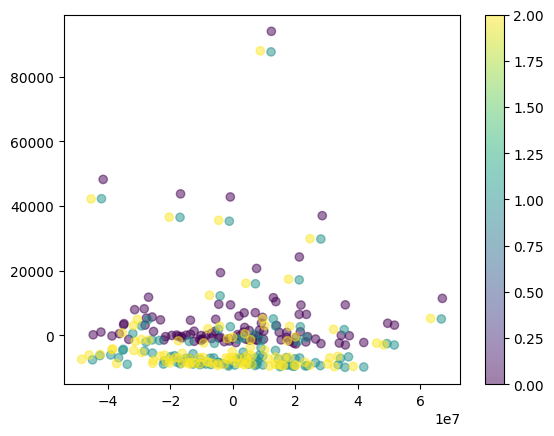


This is the results we got with this feature extraction

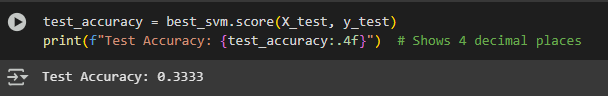

Note : Its just an image (please run this to get this results)


Feature Extraction version 2

      1. Multi-Scale Statistics:
      We check images in different scale to capture some defects like if an image is blurry at half size -> low quality scanner
      
      2. Directional Gradient:
      measures sharpness or edges in both vertical and horizontal
      Strong horizontal lines → Scanner has a dirty roller.
      Strong vertical lines → Dust on the sensor.

      3. Frequency Features:
       pattern noise or periodic lines left by scanners are easier to detect in frequency domain.

       
  

In [68]:
scanner_dirs = ['scanner1', 'scanner2', 'scanner3']
def extract_features_v2(noisy_img):
    """Enhanced feature extraction with error handling"""
    features = []

    try:
        # 1. Multi-Scale Statistics 6 features
        for scale in [1, 2, 4]:
            img_resized = cv2.resize(noisy_img,
                                   (noisy_img.shape[1]//scale,
                                    noisy_img.shape[0]//scale),
                                   interpolation=cv2.INTER_AREA)
            features.extend([np.mean(img_resized), np.std(img_resized)])

        # 2. Directional Gradients
        gx = cv2.Sobel(noisy_img, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(noisy_img, cv2.CV_32F, 0, 1, ksize=3)
        #store the mean of sq
        features.extend([np.mean(gx**2), np.mean(gy**2)])

        # 3. Enhanced Frequency Features
        fft = np.fft.fft2(noisy_img)
        fft_shift = np.fft.fftshift(fft)
        magnitude = np.log(np.abs(fft_shift) + 1e-10)

        for r in [0.1, 0.3, 0.5]:
            mask = np.zeros_like(magnitude)
            cv2.circle(mask, (mask.shape[1]//2, mask.shape[0]//2),
                      int(r * min(mask.shape)/2), 1, -1)
            features.append(np.mean(magnitude[mask==1]))

        # 4. Local Binary Patterns ( ek pattern offen kitni baar repeat hotiiii)
        lbp = local_binary_pattern(noisy_img, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp, bins=10, range=(0, 10))
        features.extend(hist)  # Use entire histogram as features

        # 5. Defect Detection
        features.extend([
            np.sum(noisy_img > np.percentile(noisy_img, 99)),
            np.sum(noisy_img < np.percentile(noisy_img, 1))
        ])

    except Exception as e:
        print(f"Feature extraction failed: {e}")
        return None

    return np.array(features)


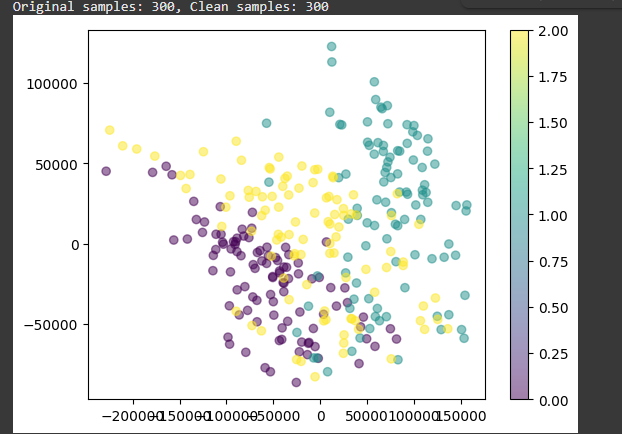

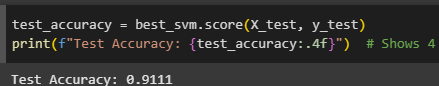

This was the results we got using this feature extraction which mainly focused on most pattern noise , hot and dead pixels (scanner 3)


3rd method : Hybrid

In [112]:
from scipy import stats
import numpy as np
import cv2

def extract_featuresFinal(img):
    """
    Combines:
    1. Paper's 16D feature vector (average row stats + row correlations)
    2. Your effective frequency
    Total: 16 (paper) + 12  = 28 features
    """
    features = []

    # 1. Avg and statistics (5 features)
    avg_row = np.mean(img, axis=0)
    features.extend([
        np.mean(avg_row),
        np.median(avg_row),
        np.std(avg_row),
        stats.skew(avg_row),
        stats.kurtosis(avg_row)
    ])

    # 2. Row correlations
    row_corrs = [np.corrcoef(avg_row, row)[0,1] for row in img]
    features.extend([
        np.mean(row_corrs),
        np.median(row_corrs),
        np.std(row_corrs),
        np.max(row_corrs) - np.min(row_corrs),  # Banding strength
        stats.skew(row_corrs),  # Distribution shape
        np.percentile(row_corrs, 5),  # Worst-case deviation
        # Additional robust moments:
        np.percentile(row_corrs, 25),
        np.percentile(row_corrs, 75),
        stats.iqr(row_corrs),   # Interquartile range
        len([x for x in row_corrs if x < 0]),  # Negative correlations
        np.sum(np.array(row_corrs) < 0.5)      # Weak correlations
    ])

    # --- Your Effective Additions (12 features) ---
    # 1. Frequency Bands (3 features)
    fft = np.abs(np.fft.fftshift(np.fft.fft2(img)))
    for r in [0.1, 0.3, 0.5]:  # Low/mid/high frequencies
        mask = np.zeros_like(fft)
        cv2.circle(mask, (mask.shape[1]//2, mask.shape[0]//2),
                  int(r * min(mask.shape)/2), 1, -1)
        features.append(np.mean(fft[mask==1]))

    # 2. LBP Texture (5 features: histogram bins 0-4)
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    features.extend(np.histogram(lbp, bins=5, range=(0, 10))[0])

    # 3. Defect Detection (4 features)
    features.extend([
        np.sum(img > np.percentile(img, 99)),  # Hot pixels
        np.sum(img < np.percentile(img, 1)),   # Dead pixels
        np.mean(cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)**2),  # Horizontal edges
        np.mean(cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)**2)    # Vertical edges
    ])

    return np.array(features)

Row-wise correlations detect scanner-specific banding patterns.

FFT magnitudes identify periodic sensor defects as some scanner noise isn't visible in normal pixel values but shown in wave patterns
ex: diagonal interference

In [107]:
from tqdm import tqdm #for processing bars
from scipy import stats
from skimage.feature import local_binary_pattern
X = []
y = []

Now we'll read noisy images ,extract 16 features from each image storing in X and y (labels)

    features = extract_features_v2(img)
    Use Different extract_features function to extract the other 2 versions

    Currently using hybrid

In [108]:
scanner_dirs = ['scanner1', 'scanner2', 'scanner3']

for scanner_idx, scanner_name in enumerate(scanner_dirs):
  scanner_path = os.path.join('scanner-data', scanner_name)
  # print(scanner_path)
  images = [f for f in os.listdir(scanner_path) if f.endswith('.jpg')]
  #read the image
  for img_file in tqdm(images, desc=f"Processing {scanner_name}"):
    img_path = os.path.join(scanner_path, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if images is None :
      print("Skip")
      continue

    #extract featue
    features = extract_featuresFinal(img)
    X.append(features)
    y.append(scanner_idx)

Processing scanner3:   1%|          | 1/100 [00:00<00:27,  3.55it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Processing scanner3: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


In [111]:
X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Original samples: 300, Clean samples: 299


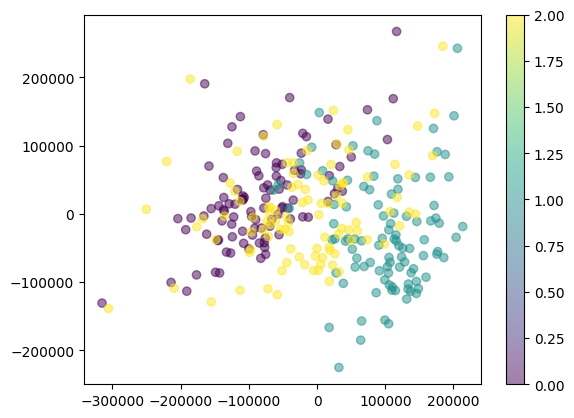

In [113]:
import numpy as np
# Get indices of non-NaN rows
non_nan_mask = ~np.isnan(X).any(axis=1)
X_clean = X[non_nan_mask]
y_clean = y[non_nan_mask]

print(f"Original samples: {len(X)}, Clean samples: {len(X_clean)}")

# Now use X_clean and y_clean for PCA
from sklearn.decomposition import PCA

def plot_feature_space(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y, alpha=0.5)
    plt.colorbar()
    plt.show()

plot_feature_space(X_clean, y_clean)

In [114]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels in y:", np.unique(y))



X shape: (300, 28)
y shape: (300,)
Unique labels in y: [0 1 2]


Importing important libraries

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [116]:
# Use the already cleaned data (20,310 samples)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean
)

# Proceed with scaling and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [117]:
import numpy as np
print(f"Number of NaN values in X: {np.isnan(X).sum()}")
print(f"Number of NaN values in X_train: {np.isnan(X_train).sum()}")

Number of NaN values in X: 9
Number of NaN values in X_train: 0


In [118]:
# Get indices of non-NaN rows
non_nan_mask = ~np.isnan(X).any(axis=1)
X_clean = X[non_nan_mask]
y_clean = y[non_nan_mask]

print(f"Original samples: {len(X)}, Clean samples: {len(X_clean)}")

Original samples: 300, Clean samples: 299


Data Processing

In [79]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# #rescale the features to have 0 mean and std =1
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)



In [119]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [120]:
param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel width
    'kernel': ['rbf', 'poly']        # Kernel type
}

svm = SVC(class_weight='balanced') #handel imbalance

# Grid search with 5-fold CV
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_svm = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}


In [122]:
test_accuracy = best_svm.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")  # Shows 4 decimal places

Test Accuracy: 0.8667



Model Evaluation

Test Accuracy: 0.8667 (86.67%)

Classification Metrics:


,precision,recall,f1-score,support
Scanner1,0.879,0.967,0.921,30.000000
Scanner2,0.955,0.700,0.808,30.000000
Scanner3,0.800,0.933,0.862,30.000000
accuracy,0.867,0.867,0.867,0.866667
macro avg,0.878,0.867,0.863,90.000000
weighted avg,0.878,0.867,0.863,90.000000


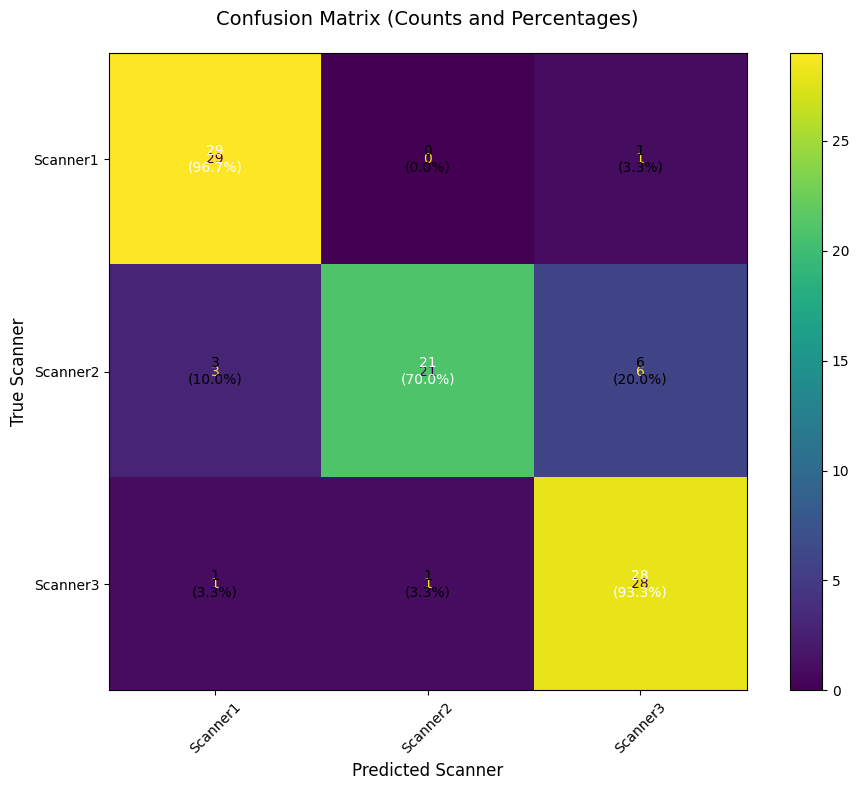


Per-Class Performance:


,Scanner,Accuracy,Samples
0,Scanner1,96.67%,30
1,Scanner2,70.00%,30
2,Scanner3,93.33%,30



Misclassification Patterns:


col_0,Scanner1,Scanner2,Scanner3
row_0,,,
Scanner1,0,0,1
Scanner2,3,0,6
Scanner3,1,1,0


In [123]:
from sklearn.metrics import (classification_report,
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            accuracy_score)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_model(model, X_test, y_test, scanner_names):
    """Comprehensive model evaluation with visual diagnostics"""

    # 1. Basic predictions and accuracy
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"\n{'='*50}\nModel Evaluation\n{'='*50}")
    print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # 2. Enhanced classification report
    print("\nClassification Metrics:")
    report = classification_report(y_test, y_pred,
                                 target_names=scanner_names,
                                 output_dict=True)

    # Convert to styled DataFrame
    report_df = pd.DataFrame(report).transpose()
    styled_report = report_df.style\
        .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])\
        .format('{:.3f}', subset=['precision', 'recall', 'f1-score'])
    display(styled_report)

    # 3. Advanced confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=scanner_names)
    disp.plot(cmap='viridis', values_format='d', ax=plt.gca())

    # Add annotations with percentages
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            total = cm.sum(axis=1)[i]
            percentage = cm[i,j]/total if total > 0 else 0
            plt.text(j, i, f"{cm[i,j]}\n({percentage:.1%})",
                    ha='center', va='center',
                    color='white' if cm[i,j] > cm.max()/2 else 'black',
                    fontsize=10)

    plt.title("Confusion Matrix (Counts and Percentages)", pad=20, fontsize=14)
    plt.xlabel("Predicted Scanner", fontsize=12)
    plt.ylabel("True Scanner", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 4. Per-class accuracy breakdown
    print("\nPer-Class Performance:")
    class_results = []
    for i, scanner in enumerate(scanner_names):
        class_mask = y_test == i
        class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
        n_samples = sum(class_mask)
        class_results.append([scanner, class_acc, n_samples])

    class_df = pd.DataFrame(class_results,
                          columns=['Scanner', 'Accuracy', 'Samples'])
    display(class_df.style\
           .bar(subset=['Accuracy'], align='mid', color=['#d65f5f', '#5fba7d'])\
           .format({'Accuracy': '{:.2%}'}))

    # 5. Misclassification analysis
    print("\nMisclassification Patterns:")
    misclassified = X_test[y_pred != y_test]
    misclass_counts = pd.crosstab(
        index=pd.Series(y_test[y_pred != y_test]).map(dict(enumerate(scanner_names))),
        columns=pd.Series(y_pred[y_pred != y_test]).map(dict(enumerate(scanner_names))),
    )

    if not misclass_counts.empty:
        display(misclass_counts.style.background_gradient(cmap='Reds'))
    else:
        print("No misclassifications found!")

    # 6. Confidence analysis (if available)
    if hasattr(model, 'predict_proba'):
        print("\nPrediction Confidence Analysis:")
        proba = model.predict_proba(X_test)

        plt.figure(figsize=(12, 6))
        for i in range(len(scanner_names)):
            plt.hist(proba[y_test==i, i], bins=20, alpha=0.6,
                    label=f'{scanner_names[i]} (true)')

        plt.axvline(x=1/len(scanner_names), color='red', linestyle='--',
                   label='Random chance')
        plt.xlabel("Predicted Probability for Correct Class", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.title("Classification Confidence Distribution", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Calculate confidence metrics
        correct_conf = proba[np.arange(len(y_test)), y_test][y_pred == y_test]
        wrong_conf = proba[np.arange(len(y_test)), y_test][y_pred != y_test]

        print(f"\nMean confidence for correct predictions: {np.mean(correct_conf):.3f}")
        print(f"Mean confidence for wrong predictions: {np.mean(wrong_conf):.3f if len(wrong_conf)>0 else 'N/A'}")

    return {
        'accuracy': test_accuracy,
        'report': report_df,
        'confusion_matrix': cm,
        'class_accuracies': class_results
    }

# Example usage:
scanner_dirs = ['Scanner1', 'Scanner2', 'Scanner3']  # Replace with your scanner names
results = evaluate_model(best_svm, X_test, y_test, scanner_dirs)

Top 10 Important Features:
hot_pixels: 0.4333 +/- 0.0281
fft_max: 0.2233 +/- 0.0353
dead_pixels: 0.1889 +/- 0.0430
fft_high: 0.1400 +/- 0.0249
dust_count: 0.1156 +/- 0.0249
fft_low: 0.0656 +/- 0.0230
fft_std: 0.0000 +/- 0.0050
kurtosis: 0.0000 +/- 0.0000
row_corr_mean: 0.0000 +/- 0.0000
std: 0.0000 +/- 0.0000


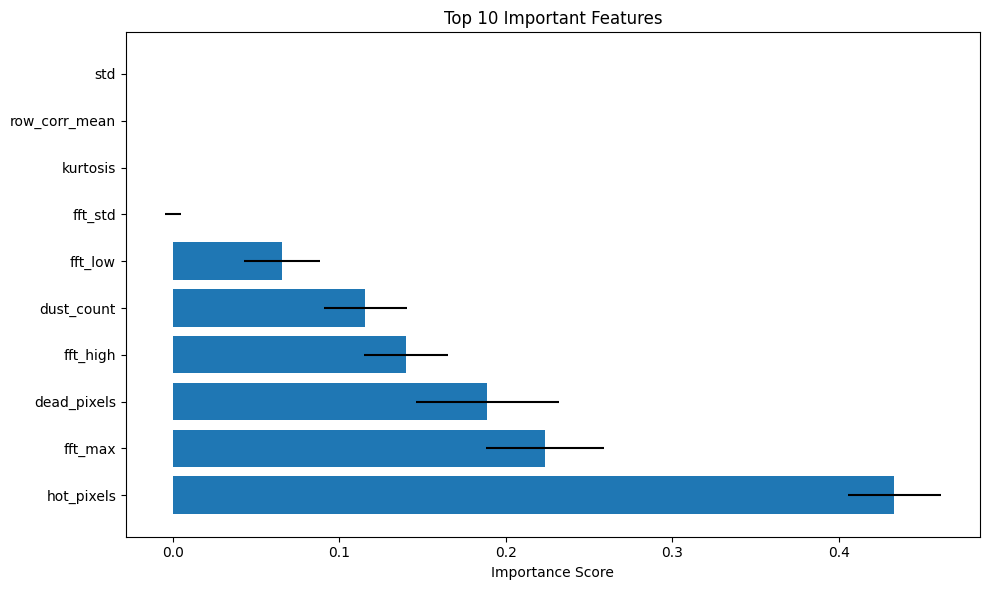

In [125]:
import pandas as pd
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_svm, X_test, y_test, n_repeats=10, random_state=42
)

# Define the actual feature names
feature_names = [
    'mean_intensity', 'median', 'std', 'skew', 'kurtosis',
    'row_corr_mean', 'row_corr_median', 'row_corr_std',
    'row_band_strength', 'row_skew', 'row_worst_dev',
    'col_std_mean', 'col_std_max', 'col_outliers',
    'fft_mean', 'fft_std', 'fft_low', 'fft_high', 'fft_max',
    'hot_pixels', 'dead_pixels', 'dust_count'
]

# Ensure all arrays are of the same length before creating the DataFrame
num_features = min(len(feature_names), len(result.importances_mean), len(result.importances_std))
# Create a DataFrame for visualization, now using actual feature_names
importance_df = pd.DataFrame({
    'feature': feature_names[:num_features],
    'importance': result.importances_mean[:num_features],
    'std': result.importances_std[:num_features]
}).sort_values('importance', ascending=False)

# Print top features with their names
print("Top 10 Important Features:")
for index, row in importance_df.head(10).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f} +/- {row['std']:.4f}")

# Plot top features
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'][:10], importance_df['importance'][:10], xerr=importance_df['std'][:10])
plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()